In [185]:
# import qutip packages
from qutip import *
import krotov
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import scipy

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

# The Model (FMO with N Sites/Qubits)

# Define the Hamiltonian and Liouvillian

We model our network model based on previous theoretical descriptions of PPCs as a network composed of distinct sites, one of which receives a single excitation (which we choose to be $\ket{1}$ for the time being) and one site to be connected to the Reaction Center/Sink (which we choose to be $\ket{N}$.  The network of $N$ sites is described by the Hamiltonian with hopping parameters fixed by geometry and dipolar structure of site interactions:

$H = \Sigma_{j = 1}^N \hbar \omega_j \sigma_j^+ \sigma_j^- + \Sigma_{j \ne l} \hbar \nu_{j,l} (\sigma_j^- \sigma_l^+ + \sigma_j^+ \sigma_l^-)$

where we define the raising and lowering operators to be $\sigma_j^+ = \ket{j}\bra{0}$ and $\sigma_j^- = \ket{0}\bra{j}$ for site $j$, and state $j$ denoting one excitation in the site $j$ and $\ket{0}$ is the zero excitation states.  $\hbar \omega_j$ are the local site energies and $\nu_{j, l}$ are the coherent tunneling amplitudes between sites $j$ and $l$ (we do not consider microscoping coupling).  Our Hilbert space is actually defined as $N + 2$ states because we define an additional sink state at $\ket{N+1}$.

We assume that the system is susceptible simultaneously to two distinct types of noise: a radiative decay process that transfers the excitation energy in site j to the environment with a rate $\Gamma_j$ and a pure dephasing process with rate $\gamma_j$ that destroyes phase coherence for localized excitations.  We model the system's density matrix by a Markovian Lindbladian Master Equation:

$\dot{\rho} = -i[H, \rho] + \mathcal{L}_{rad}(\rho)+ \mathcal{L}_{deph}(\rho)$

where we define the local radiative and dephasing terms by the Lindblad superoperators $\mathcal{L}_{rad}$ and $\mathcal{L}_{deph}$:

$\mathcal{L}_{deph} = \Sigma_{j = 1}^N\gamma_j[-\{\sigma_j^+ \sigma_j^-, \rho\} + 2\sigma_j^+ \sigma_j^- \rho \sigma_j^+ \sigma_j^-]$

$\mathcal{L}_{diss}(\rho) = \Sigma_{j = 1}^N\Gamma_j[-\{\sigma_j^+ \sigma_j^-, \rho\} + 2\sigma_j^- \rho \sigma_j^+])$

where $\{A, B\}$ describes an anticommutator relation.

We measure the total excitation transfer by the population transferred to the Reaction Center, which we model as the sink node as $N + 1$ that is populated by an irreversible decay process with rate $\Gamma_{N+ 1}$ from a site $k$ (which we choose to be $\ket{N}$ and described by a Lindblad operator:

 $\mathcal{L}_{sink}(\rho) = \Gamma_c[2 \sigma_c^+ \sigma_k^- \rho \sigma_k^+ \sigma_c^- - \{\sigma_k^+ \sigma_c^- \sigma_c^+, \rho \}]))$

Our objective is to measure the excitation transfer by measuring the population to the sink.  The sink population is modeled by $p_{sink}(t) = 2\Gamma_c \int_0^t\rho_{kk}(t') dt'$.

In [239]:
# define units for the problem
hbar = 1;

In [240]:
# define FMO system for initial state excited at state 1
N = 3;

#input:

# N = number of sites, site N + 1 being the sink, and a site 0 being the zero exciton state, 
# thus giving a Hilbert space of N + 2

# omega = local site energies, given in an array of length N
# nu = coherent tunneling amplitude between site i and j, where i,j are from 1 to N, given as an NxN symmetric matrix
# Gamma = rate or radiative decay process that transfers excitation in site j to environment, given as array of length N
# gamma = rate of pure dephasing that destroys phase coherence for localized excitations, given as array of length N
# Gamma_c = rate of irreversible decay from site k to sink, given as double 
# tlist = evolution time

def FMO_solve(N, omega, nu, Gamma, gamma, Gamma_c, tlist):
    # instance variables 
    # create vacuum state 
    vac = qutip.basis(N + 2, 0)

    # create raising and lowering operators 
    sigma_minus = qutip.destroy(N + 2)
    sigma_plus = sigma_minus.dag()
    
    # define raising and lowering operators for site j, returns operator
    def raise_operator(j):
        siteState = qutip.basis(N + 2, j)
        return siteState*vac.dag()

    def lower_operator(j):
        siteState = qutip.basis(N + 2, j)
        return vac*(siteState.dag())
    
    # create the Hamiltonian summing over all sites given N sites and site energies vector omega
    def Hamiltonian_states(omega):
        M = np.zeros([N + 2, N + 2])
        qutip.Qobj(M);
        
        for i in range(N):
            H = hbar * omega[i] / 2 * raise_operator(i + 1) * lower_operator(i + 1)
            M = M + H
        return M
    
    # define interaction Hamiltonian summing over all sites N given matrix nu for coherent tunneling amplitudes 
    def Hamiltonian_interaction(nu):
        M = np.zeros([N + 2, N + 2])
        qutip.Qobj(M);

        for i in range(N):
            for j in range(N):
                if (i != j):
                    H = hbar * nu[i,j] * (lower_operator(j + 1) * raise_operator(i + 1) + raise_operator(j + 1) * lower_operator(i + 1))
                    M = M + H
        return M
    
    #define the sink state k and generate density matrix for that state k
    def target_state(k):
        return qutip.ket2dm(raise_operator(k) * vac)
    
    # Liouvillian for coupled 2-site system
    
    # define initial density matrix for initial state, which we take to be |1>
    rho0 = qutip.ket2dm(raise_operator(1) * vac)
    
    # Construct Hamiltonian 
    H = Hamiltonian_states(omega) + Hamiltonian_interaction(nu)
    
    # Define collapse operators
    c_ops_list = []
    # add radiative and dephasing dissipation
    for i in range(N):
        c_ops_list.append(np.sqrt(2 * Gamma[i]) * lower_operator(i + 1)) # radiative
        c_ops_list.append(np.sqrt(2 * gamma[i]) * raise_operator(i + 1) * lower_operator(i + 1)) # dephasing
    # add sink Lindblad collapse 
    k = N
    c_ops_list.append(np.sqrt(2 * Gamma_c) * raise_operator(N + 1) * lower_operator(k))
    
    return qutip.mesolve(H = H, rho0 = rho0, tlist = tlist, c_ops = c_ops_list, e_ops = target_state(N))

In [268]:
def plot_population(result, Gamma_c):
    fig, ax = plt.subplots()
   
    ax.plot(
        result.times,
        np.abs(np.array(result.expect[0])),label='$p_{k}$'
    )
    ax.plot(result.times[0:len(result.times) - 1], Gamma_c * 2 * scipy.integrate.cumtrapz(y = np.abs(np.array(result.expect[0])), x = result.times, dx = dt),label='$p_{sink}$')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title('FMO Evolution')
    plt.show(fig)
    return [result.times[0:len(result.times) - 1], Gamma_c * 2 * scipy.integrate.cumtrapz(y = np.abs(np.array(result.expect[0])), x = result.times, dx = dt)]

In [269]:
def uniformFMO(N, site_energy, tunneling_strength, rad_rate, deph_rate, Gamma_c, T, nt):
    omega0 = np.asarray(tunneling_strength*np.ones(n))
    omega = omega0 * site_energy
    
    nu = np.asarray(tunneling_strength*np.ones(shape = (n,n)))
    
    Gamma = np.asarray(np.ones(n))
    Gamma = np.asarray(Gamma) * rad_rate
    
    gamma = np.asarray(np.ones(n))
    gamma = np.asarray(gamma) * deph_rate
    
    Gamma_c = 1.0
    
    tlist = np.linspace(0, T, nt)
    dt = tlist[1] - tlist[0]

    result = FMO_solve(n, omega, nu, Gamma, gamma, Gamma_c, tlist)
    return plot_population(result, Gamma_c)

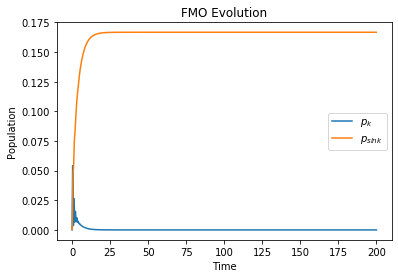

In [270]:
n = 7
site_energy = 1.0
tunneling_strength = 1.0
rad_rate = 0.0
deph_rate = 0.0
Gamma_c = 1.0
T = 200
nt = 2500

nodiss = uniformFMO(n, site_energy, tunneling_strength, rad_rate, deph_rate, Gamma_c, T, nt)

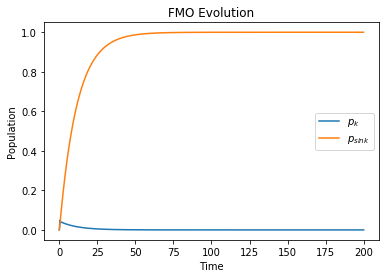

In [273]:
n = 7
site_energy = 1.0
tunneling_strength = 1.0
rad_rate = 0.0
deph_rate = 1.0
Gamma_c = 1.0
T = 200
nt = 2500

unideph = uniformFMO(n, site_energy, tunneling_strength, rad_rate, deph_rate, Gamma_c, T, nt)

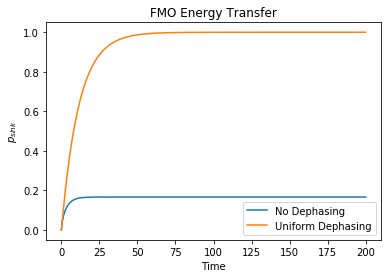

In [278]:
fig, ax = plt.subplots()

ax.plot(nodiss[0], nodiss[1],label='No Dephasing')
ax.plot(unideph[0], unideph[1],label='Uniform Dephasing')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('$p_{sink}$')
ax.set_title('FMO Energy Transfer')
plt.show(fig)